# Modelling

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from prettytable import PrettyTable

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")    


In [ ]:
df = pd.read_csv('aemo_wu_merged.csv', index_col = 0)
df.head()

In [22]:
df.columns

Index(['timestamp', 'Operational Demand (MW)', 'temperature(celcius)',
       'dew_point(celcius)', 'humidity(%)', 'Wind', 'wind_speed(mph)',
       'wind_gush(mph)', 'pressure(in)', 'precip.(in)', 'Condition',
       'Trading Interval Time', 'new_timestamp', 'year', 'month', 'day',
       'hour', 'minute', 'Day_of_week', 'Day_of_month', 'Day_of_year',
       'has_Wind'],
      dtype='object')

## Data Preparation

In [ ]:
# Seperate timestamp and set several new variables
def wind_ans(x):
    if x > 0: 
        return 1 
    else:
        return 0
df[['Date','Trading Interval Time']] = df['timestamp'].str.split(" ",expand=True)  # split time into date and interval timedf['Date'] = pd.to_datetime(df['Date'])
# df['year'] = df['Date'].dt.year
# df['month'] = df['Date'].dt.month
# df['day'] = df['Date'].dt.day
df['Date'] = pd.to_datetime(df['Date'])
df['new_timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['year'] = df['new_timestamp'].dt.year
df['month'] = df['new_timestamp'].dt.month
df['day'] = df['new_timestamp'].dt.day
df['hour'] = df['new_timestamp'].dt.hour
df['minute'] = df['new_timestamp'].dt.minute
df['Day_of_week'] = df['new_timestamp'].dt.dayofweek
df['Day_of_month'] = df['new_timestamp'].dt.day
df['Day_of_year'] = df['new_timestamp'].dt.dayofyear
df['has_Wind'] = df['wind_speed(mph)'].apply(wind_ans) 
df.set_index('timestamp', inplace=True, drop=True)
df.reset_index(inplace=True)
df.head()

In [68]:
# def create_time_features(df_in):
#     df = df_in
#     df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
#     df['Year'] = df['timestamp'].dt.year
#     df['Month'] = df['timestamp'].dt.month
#     df['Hour'] = df['timestamp'].dt.hour
#     df['Day_of_week'] = df['timestamp'].dt.dayofweek
#     df['Day_of_month'] = df['timestamp'].dt.day
#     df['Day_of_year'] = df['timestamp'].dt.dayofyear
#     df.set_index('timestamp', inplace=True, drop=True)
#     # df = df.astype('int')
#     df.reset_index(inplace=True)
#     time_features_df = df
#     return time_features_df

In [48]:
# df_a = create_time_features(df)
# df_a.columns.tolist()
# df_a.head()

            timestamp  Operational Demand (MW)  temperature(celcius)  \
0 2017-01-22 00:00:00                 1815.214                  20.0   
1 2017-01-22 00:30:00                 1777.040                  20.0   
2 2017-01-22 01:00:00                 1745.448                  18.9   
3 2017-01-22 01:30:00                 1729.164                  18.9   
4 2017-01-22 02:00:00                 1714.276                  18.9   

   dew_point(celcius)  humidity(%) Wind  wind_speed(mph)  wind_gush(mph)  \
0                15.0         73.0  SSW              9.0             0.0   
1                15.0         73.0  SSW             10.0             0.0   
2                15.0         78.0  SSW              9.0             0.0   
3                15.0         78.0  SSW             15.0             0.0   
4                12.8         68.0  SSW             18.0             0.0   

   pressure(in)  precip.(in)  ... day hour minute  Day_of_week  Day_of_month  \
0          29.0          0.0  

In [78]:
df.head()

             timestamp  Operational Demand (MW)  temperature(celcius)  \
0  2017-01-22 00:00:00                 1815.214                  20.0   
1  2017-01-22 00:30:00                 1777.040                  20.0   
2  2017-01-22 01:00:00                 1745.448                  18.9   
3  2017-01-22 01:30:00                 1729.164                  18.9   
4  2017-01-22 02:00:00                 1714.276                  18.9   

   dew_point(celcius)  humidity(%) Wind  wind_speed(mph)  wind_gush(mph)  \
0                15.0         73.0  SSW              9.0             0.0   
1                15.0         73.0  SSW             10.0             0.0   
2                15.0         78.0  SSW              9.0             0.0   
3                15.0         78.0  SSW             15.0             0.0   
4                12.8         68.0  SSW             18.0             0.0   

   pressure(in)  precip.(in)  ...       new_timestamp  year month day  hour  \
0          29.0          

In [127]:
#select_col=['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'year','Day_of_week','Day_of_month','Day_of_year']
df.index = df['Date']
select_col = ['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
'Day_of_week', 'Day_of_month', 'Day_of_year']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))
model_df=df[select_col]
training_dat = model_df[(model_df.index < '2021-12-01') | ('2022-04-01' < model_df.index)]
testing_dat = model_df[(model_df.index >= '2021-12-01') & ('2022-04-01' > model_df.index)]

X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = testing_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = testing_dat['Operational Demand (MW)']


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Function Preparation

In [87]:
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)

## Feature Scale

In [25]:
# stdsc=StandardScaler()
# X_train_sc = stdsc.fit_transform(X_train)
# X_test_sc = stdsc.transform(X_test)

## Decision Tree

In [124]:
tree_reg = DecisionTreeRegressor(criterion='mse',# depth of tree 
                                max_depth = 20, min_samples_leaf=1, random_state=42)

# param_grid_dtree = dict(
#     max_depth =[None,15,20,25],
#     min_samples_leaf=[5,50,100])

# grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=1,return_train_score=True)

tree_reg.fit(X_train,y_train)
y_pred_tree = tree_reg.predict(X_test)
# dtscore=ModelScore(y_test,y_pred_tree)
# dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('training mape', mape)
ImportanceDisplay('tree_reg')
# print(grid_dtree.best_estimator_)
# print(grid_dtree.best_score_)


training mape 12.94542344095279
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|         day          | 0.1669 |
|         hour         | 0.0345 |
|    wind_gush(mph)    | 0.0229 |
|         year         | 0.0103 |
|        month         | 0.0005 |
|     Day_of_month     | 0.003  |
|  dew_point(celcius)  | 0.0445 |
|     Day_of_week      | 0.0037 |
|   wind_speed(mph)    | 0.012  |
|     pressure(in)     | 0.5005 |
|        minute        | 0.0056 |
|     Day_of_year      | 0.0586 |
| temperature(celcius) | 0.0108 |
|     humidity(%)      | 0.126  |
+----------------------+--------+


In [125]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_tree = pd.DataFrame(y_test)
predict_table_tree.insert(1,'predict',y_pred_tree)
predict_table_tree

            Operational Demand (MW)   predict
Date                                         
2021-12-01                 1788.716  1788.960
2021-12-01                 1768.478  1788.960
2021-12-01                 1756.662  1774.752
2021-12-01                 1735.248  1774.752
2021-12-01                 1724.418  1761.432
...                             ...       ...
2022-03-31                 2496.326  2014.112
2022-03-31                 2418.866  2309.610
2022-03-31                 2323.210  2335.514
2022-03-31                 2245.612  2136.864
2022-03-31                 2178.444  2040.502

[5808 rows x 2 columns]

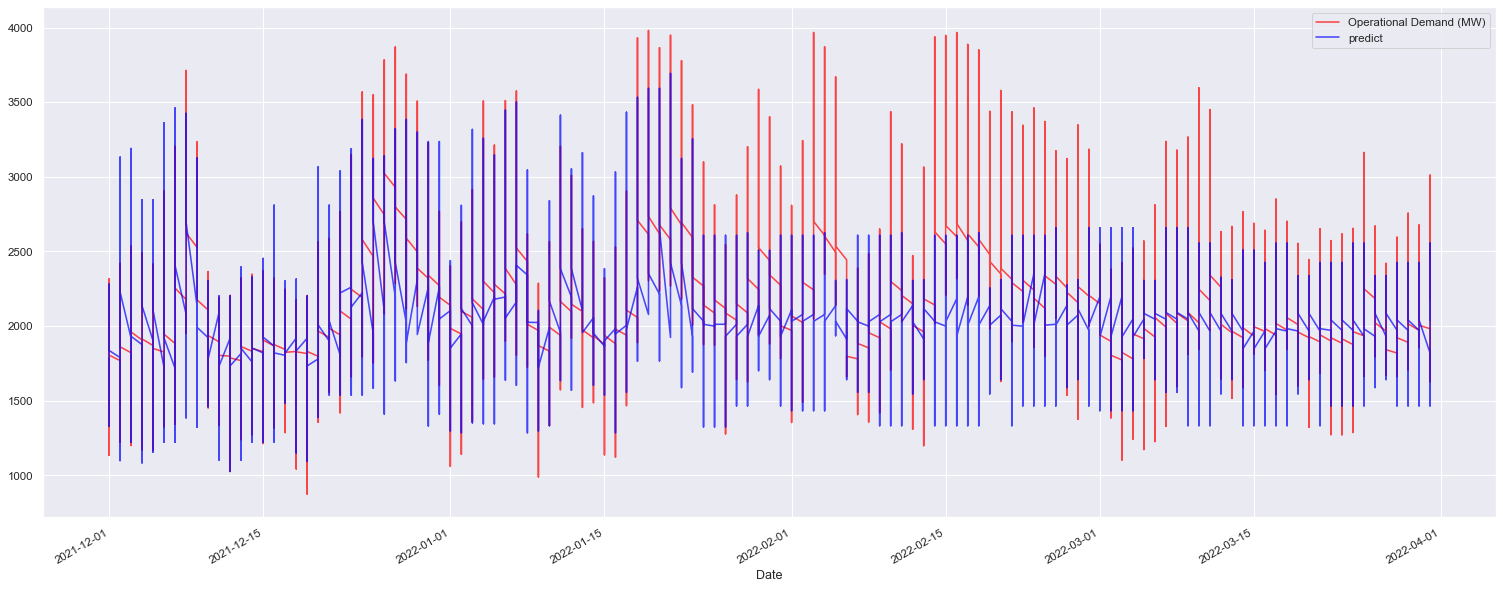

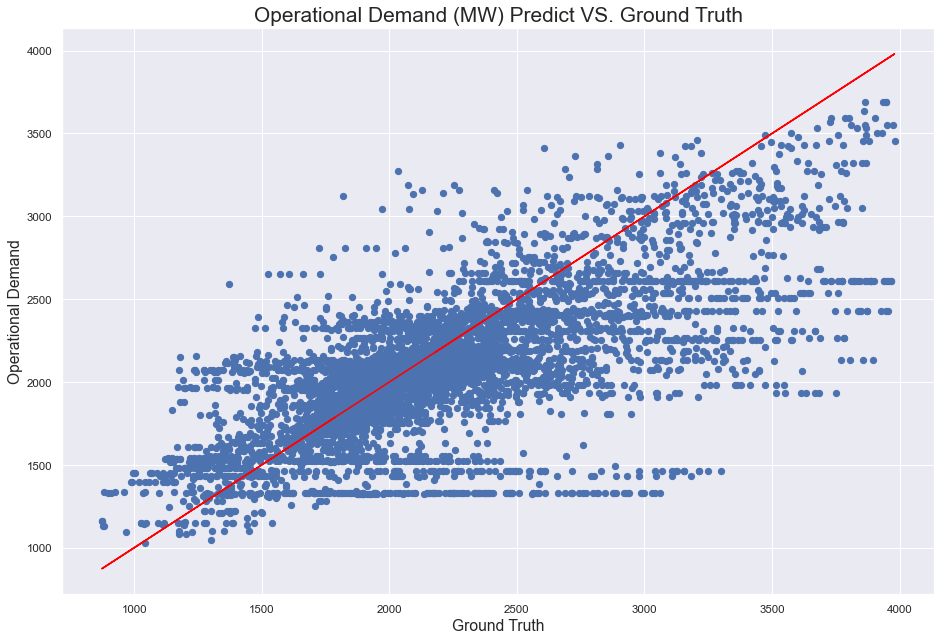

In [126]:
predict_table_tree.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

## Random Forest

In [102]:
forest = RandomForestRegressor(criterion='mse', 
                                max_depth=5, # depth of tree 
                                min_samples_leaf=10, 
                                random_state=42)

forest.fit(X_train, y_train)
y_predict_forest = forest.predict(X_test)
ny_test = len(y_test)
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('training mape', mape)

rfscore=ModelScore(y_test,y_predict_forest)
rfscore
ImportanceDisplay('forest')
# print(forest.best_estimator_)
# print(forest.best_score_)


training mape 13.395570904119683
Mean absolute error =  298.3671
Mean squared error =  170653.8648
Median absolute error =  211.0411
explained variance error =  0.5197
R2 error =  0.4596
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|         day          | 0.1591 |
|         hour         | 0.004  |
|    wind_gush(mph)    | 0.0001 |
|         year         | 0.0002 |
|        month         |  0.0   |
|     Day_of_month     |  0.0   |
|  dew_point(celcius)  | 0.0099 |
|     Day_of_week      |  0.0   |
|   wind_speed(mph)    |  0.0   |
|     pressure(in)     | 0.6666 |
|        minute        |  0.0   |
|     Day_of_year      | 0.0552 |
| temperature(celcius) |  0.0   |
|     humidity(%)      | 0.1048 |
+----------------------+--------+


In [28]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table = pd.DataFrame(y_test)
predict_table.insert(1,'predict',y_predict_forest)
predict_table

            Operational Demand (MW)      predict
Date                                            
2021-12-01                 1788.716  1822.874288
2021-12-01                 1768.478  1793.885026
2021-12-01                 1756.662  1793.885026
2021-12-01                 1735.248  1757.625139
2021-12-01                 1724.418  1757.625139
...                             ...          ...
2022-03-31                 2496.326  2066.355304
2022-03-31                 2418.866  2066.355304
2022-03-31                 2323.210  2066.355304
2022-03-31                 2245.612  2066.355304
2022-03-31                 2178.444  2066.355304

[5808 rows x 2 columns]

In [99]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

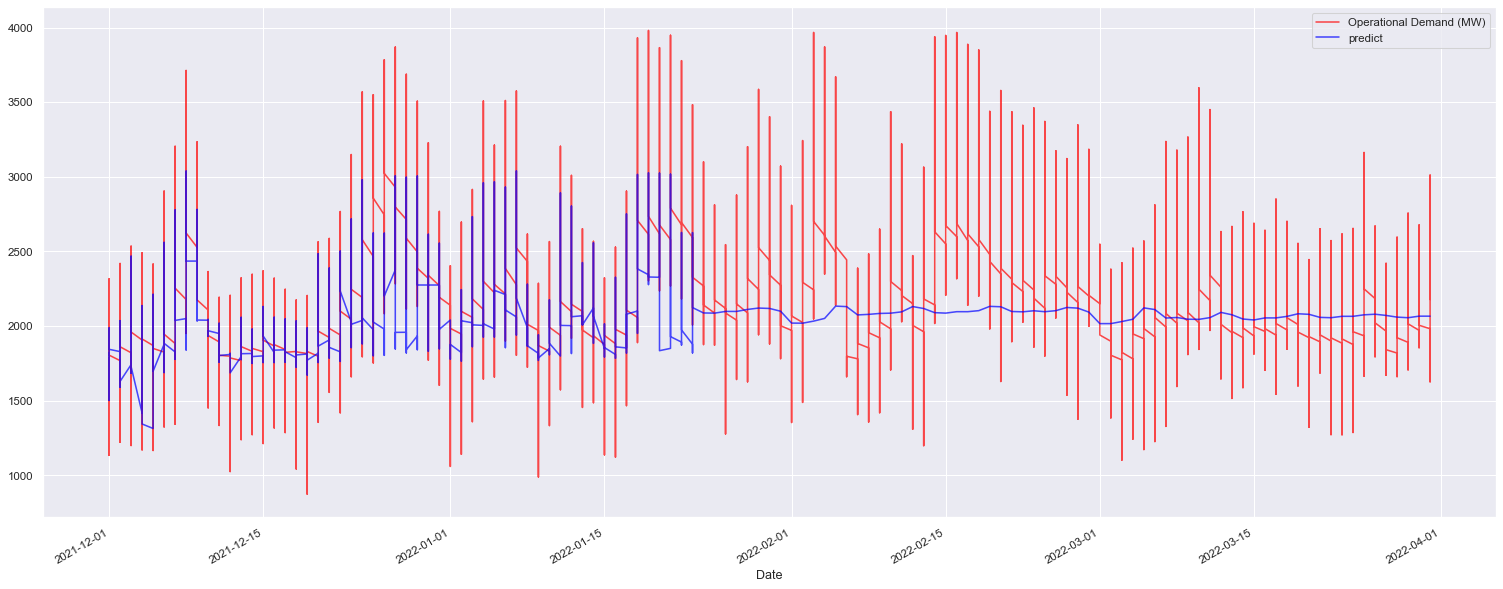

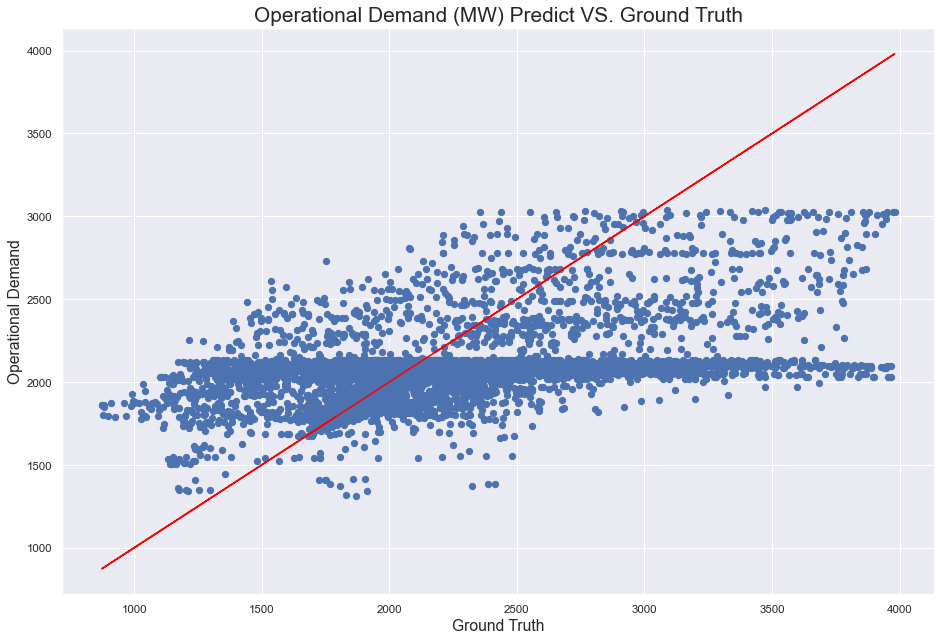

In [96]:
predict_table.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table['Operational Demand (MW)'], predict_table['predict'])
plt.plot(predict_table['Operational Demand (MW)'],predict_table['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()